In [500]:
%reset

In [586]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

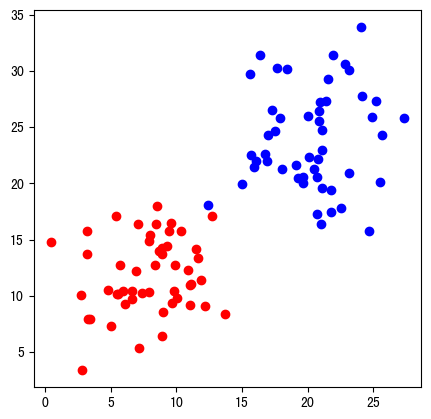

In [502]:
# 获取数据集（具有正态分布的）
x_1_1 = pd.Series(np.random.normal(loc=22, scale=4, size=50), name='x1')
x_1_2 = pd.Series(np.random.normal(loc=24, scale=4, size=50), name='x2')
y_1 = pd.Series(['blue'] * 50, name='target')

x_2_1 = pd.Series(np.random.normal(loc=8, scale=3, size=50), name='x1')
x_2_2 = pd.Series(np.random.normal(loc=12, scale=3, size=50), name='x2')
y_2 = pd.Series(['red'] * 50, name='target')

plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(x_1_1, x_1_2, c='blue')
plt.scatter(x_2_1, x_2_2, c='red')
plt.show()

tmp_data_1 = pd.concat([x_1_1, x_1_2, y_1], axis=1)
tmp_data_2 = pd.concat([x_2_1, x_2_2, y_2], axis=1)
data = pd.concat([tmp_data_1, tmp_data_2], axis=0)
data = shuffle(data).reset_index(drop=True)  # 打乱样本顺序

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1])

# 归一化
transfer = MinMaxScaler(feature_range=(0, 10))
x_train = transfer.fit_transform(X=x_train)
x_test = transfer.transform(X=x_test)


# CUC 的主类

In [587]:
# ------*------ coding: utf-8 ------*------
# @Time    : 2023/3/27 18:45
# @Author  : 冰糖雪狸 (NekoSilverfox)
# @Project : CUC
# @File    : CodingUnitClassifier.py
# @Software: PyCharm
# @Github  ：https://github.com/NekoSilverFox
# -----------------------------------------
import numpy as np
import pandas as pd
from enum import Enum
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


class CodingUnitClassifier(object):
    """编码单元分类器预估器（estimator）"""
    class CUType(Enum):
        NOT_FINAL_CU = -1
        EMPTY_CU = -2

    def __init__(self, num_refinement_splits=0, threshold_value=1.0, is_draw_2D=False, color_map=[], pic_save_path=None, **kw) -> None:
        """初始化

        Args:
            num_refinement_splits (int, optional): 细化分割次数. Defaults to 0.
            threshold_value (int, optional): 临界值. Defaults to  1.0.
            is_draw_2D (bool, optional): 当绘制 2D 数据集，是否绘制中途图像. Defaults to False.
        """
        self.is_draw_2D = is_draw_2D
        self.pic_save_path = pic_save_path
        self.color_map = color_map
        self.draw_count = 0  # 绘制次数记录（还用于拓展保存时的文件名）

        self.split_count = 0  # 分割次数计数器
        self.num_refinement_splits = num_refinement_splits
        self.threshold_value = threshold_value  # 临界值：当某个 CU 中某种粒子占比超过这个阈值，则暂停分割

        self.transfer_LabelEncoder = None  # 目标值的转换器（转为数字）

        self.N_train = None  # 训练集的维度
        self.X_train = None  # 特征值（训练集）
        self.y_train = None  # 目标值（训练集）
        self.df_train = None  # 以 pandas.DataFream 形式的训练接数据（特征值和训练集是合并在一起的）。目标值的索引为 `target`，特征值的索引为 `x`，x 为从 0 开始的数字

        self.CU_min = None  # 编码单元范围最小值
        self.CU_max = None  # 编码单元范围最小值

        self.arrCU_start_points = None  # 编码单元起始点列表
        self.arrCU_dL = None  # arrCU_start_points 对应位置的编码单元的边长 `dL`
        self.arrCU_is_enable = None  # arrCU_start_points 对应位置的编码单元是否启用，True 代表启用，False 代表不启用
        self.arrCU_final_target = None  # arrCU_start_points 对应位置的编码单元的最终预测类别（-1 代表无类别）
        self.arrCU_force_infection = None  # arrCU_start_points 对应位置的编码单元的感染力度 (force of infection)

    def arr_checker(self):
        """
        检测当前 self 内数组的长度是否正常
        :return:
        """
        if self.arrCU_start_points.shape[0] != self.arrCU_dL.shape[0] != self.arrCU_is_enable.shape[0] != \
                self.arrCU_final_target.shape[0]:
            raise ValueError(f'arrCU 长度异常：\n'
                             f'\t{self.arrCU_start_points.shape[0]}'
                             f'\t{self.arrCU_dL.shape[0]}'
                             f'\t{self.arrCU_is_enable.shape[0]}'
                             f'\t{self.arrCU_final_target.shape[0]}')

    def is_point_in_CU(self, point: np.ndarray, start_point: np.ndarray, dL: float) -> bool:
        """
        判断点（样本）point，是否在编码单元中
        :param point: 需要判断的点
        :param start_point: 编码单元的起始点
        :param dL: 编码单元的边长
        :return: True-在这个 CU 中；False：不在这个 CU 中
        """
        point = np.array(point)
        start_point = np.array(start_point)
        end_point = np.array(start_point + dL)  # 结束点
        if (point > start_point).all() and (point < end_point).all():
            return True
        else:
            return False

    def is_CU_need_split(self, arr1d_start_points: np.ndarray, dL: np.float) -> np.int:
        """判断当前 CU 是否需要继续预分割（如果需要返回 -1，如果不需要返回当前 CU 所属的目标值，并且 -2 代表为空白 CU）

        Args:
            arr1d_start_points (np.ndarray): 当前 CU 的起始点
            dL (np.float): 当前 CU 的边长

        Raises:
            ValueError: _description_
            ValueError: _description_

        Returns:
            _type_: True为需要进一步分割，如果不需要返回当前 CU 所属的目标值
        """
        if dL <= 0:
            raise ValueError(f'[CUC-ERROR] dl can not <= 0, your dL is {dL}')
        if arr1d_start_points.shape[0] != self.N_train:
            raise ValueError(
                f'[CUC-ERROR] arr1d_start_points.shape not correct: arr1d_start_points.shape is {arr1d_start_points.shape}, '
                f'should be ({self.N_train}, )')

        s_type_count = pd.Series(index=np.unique(self.y_train)).fillna(value=0)  # 计数器，列索引为类别，对应位置数据为该 CU 中此种类粒子数量

        # 遍历判断点是否在这个 CU  中
        for col, col_target in zip(self.X_train, self.y_train):  # col_target 为当前行的目标值
            # 判断粒子在此维度上是否介于 CU 的起始点和结束点
            if self.is_point_in_CU(point=col, start_point=arr1d_start_points, dL=dL):
                s_type_count[col_target] += 1

        # -1 代表这个编码单元里没有任何粒子，为空白编码单元
        if 0 == s_type_count.sum():
            return self.CUType.EMPTY_CU.value

        # 如果不是空 CU，则看看某种 target 的粒子占比是否达到阈值
        s_type_count = s_type_count / s_type_count.sum()  # 转换为概率
        if (s_type_count.max() >= self.threshold_value) and \
                (1 == s_type_count[s_type_count.values == s_type_count.max()].shape[0]):  # 不允许出现两种相同概率
            return s_type_count[s_type_count.values == s_type_count.max()].index[0]
        else:
            return self.CUType.NOT_FINAL_CU.value

    def split_CU_and_update2arrCU(self, index_start_points: int) -> None:
        """分割当前 CU，并将分割的结果更新到方法内部成员

        Args:
            index_start_points (int): 需要分割 CU 的索引
        """
        if self.arrCU_is_enable[index_start_points] is False:
            raise ValueError(f'[CUC-ERROR] CU on index {index_start_points} already disable, can not continue split')

        self.arrCU_is_enable[index_start_points] = False  # 既然对这个单元分割就说明这个单元不再使用了，因为它被差分成了许多新的小单元

        start_points = self.arrCU_start_points[index_start_points]
        new_dL = self.arrCU_dL[index_start_points] / 2
        end_points = np.array(start_points + new_dL)

        # 生成包含所有可能性组合的列表
        combinations = []
        for i in range(2 ** self.N_train):
            new_combination = []
            for j in range(self.N_train):
                if i & (1 << j):
                    new_combination.append(end_points[j])
                else:
                    new_combination.append(start_points[j])
            combinations.append(new_combination)

        print(f'\n\n[INFO] -------------split-------------\n'
              f'new_dL: {new_dL}\n'
              f'new_combination:\n{combinations}')

        # 分割后的 CU 添加至缓冲区
        self.arrCU_start_points = np.vstack([self.arrCU_start_points, np.array(combinations)])
        self.arrCU_dL = np.hstack([self.arrCU_dL, np.full(shape=(2 ** self.N_train,), fill_value=new_dL)])
        self.arrCU_is_enable = np.hstack([self.arrCU_is_enable, np.full(shape=(2 ** self.N_train,), fill_value=True)])
        self.arrCU_final_target = np.hstack(
            [self.arrCU_final_target,
             np.full(shape=(2 ** self.N_train,), fill_value=self.arrCU_final_target[index_start_points], dtype=np.int)])

        self.split_count += 1

    def remove_disable_points(self):
        """
        删除 arr 群组中 disable 的 point
        :return:
        """
        # 移除 self arr 数组群中 disable 的 CU，
        # 同时重新标记细化分割中产生的新空白 CU（原含有粒子的大 CU 被重新切分后可能会产生不包含粒子的新 CU）
        # 同时计算 CU 的密度
        df_X_target = pd.DataFrame(self.X_train)
        new_arrCU_start_points = None  # 编码单元起始点列表
        new_arrCU_dL = None  # arrCU_start_points 对应位置的编码单元的边长 `dL`
        new_arrCU_is_enable = None  # arrCU_start_points 对应位置的编码单元是否启用，True 代表启用，False 代表不启用
        new_arrCU_final_target = None  # arrCU_start_points 对应位置的编码单元的最终预测类别（-1 代表无类别）
        new_arrCU_force_infection = None  # arrCU_start_points 对应位置的编码单元的感染力度 (force of infection)

        for i in range(self.arrCU_start_points.shape[0]):
            if self.arrCU_is_enable[i] is False:
                continue
            dL = self.arrCU_dL[i]
            start_point = np.array(self.arrCU_start_points[i])
            end_point = np.array(start_point + dL)

            # 计算该单元中粒子的数量
            tmp_s_is_X_in_CU = ((df_X_target > start_point) & (df_X_target < end_point)).all(axis=1)  # all代表按照y周判断是否这一行都为 True（也就是 point 每个对应维度都符合），返回对应位置为 True/False 的 pd.Series
            num_point_in_CU = tmp_s_is_X_in_CU[tmp_s_is_X_in_CU == True].count()  # 该单元中粒子的数量
            target_CU = None  # 编码单元的类别
            density = None  # 密度（感染力度）

            # CU 中无粒子
            if 0 == num_point_in_CU:
                density = 0.0
                target_CU = self.CUType.EMPTY_CU.value
            else:
                density = num_point_in_CU / (dL ** self.N_train)
                target_CU = self.arrCU_final_target[i]

            # 第一个 enable 的 CU（也就是初始化 new_arr）
            if new_arrCU_is_enable is None:
                new_arrCU_start_points = np.array([self.arrCU_start_points[i]])
                new_arrCU_dL = np.array(self.arrCU_dL[i])
                new_arrCU_is_enable = np.array(self.arrCU_is_enable[i])
                new_arrCU_final_target = np.array(target_CU)
                new_arrCU_force_infection = np.array(density)

            new_arrCU_start_points = np.vstack([new_arrCU_start_points, np.array(self.arrCU_start_points[i])])
            new_arrCU_dL = np.append(new_arrCU_dL, self.arrCU_dL[i])
            new_arrCU_is_enable = np.append(new_arrCU_is_enable, self.arrCU_is_enable[i])
            new_arrCU_final_target = np.append(new_arrCU_final_target, target_CU)
            new_arrCU_force_infection = np.append(new_arrCU_force_infection, density)

        del self.arrCU_start_points
        del self.arrCU_dL
        del self.arrCU_is_enable
        del self.arrCU_final_target
        del self.arrCU_force_infection

        self.arrCU_start_points = new_arrCU_start_points
        self.arrCU_dL = new_arrCU_dL
        self.arrCU_is_enable = new_arrCU_is_enable
        self.arrCU_final_target = new_arrCU_final_target
        self.arrCU_force_infection = new_arrCU_force_infection

    def refinement_split(self, num: int) -> None:
        """
        细化分割
        :param num:细化分割的次数
        :return: None
        """
        self.arr_checker()  # 执行数组长度一致性检查

        for run_time in range(num):
            # 对每个 enable 的 CU 进行细化分割
            for i in range(self.arrCU_start_points.shape[0]):
                if self.arrCU_is_enable[i] is False:
                    continue
                self.split_CU_and_update2arrCU(index_start_points=i)
                self.arrCU_is_enable[i] = False

        self.remove_disable_points()  # 删除 disable 的粒子


    def draw_2d(self, color_map, pic_save_path=None) -> None:
        """
        绘制 2D 图形
        :param color_map:
        :param pic_save_path:
        :return:
        """
        color_map = np.array(color_map)
        if color_map.shape[0] != self.N_train:
            raise ValueError('\n[CUC-ERROR] color_map.shape[0] != self.N_train')

        plt.figure(figsize=(5, 5))

        # 绘制点
        tmp_data = pd.concat([pd.DataFrame(self.X_train), pd.Series(self.y_train)], axis=1)
        tmp_data.columns = ('x', 'y', 'target')
        for target in np.unique(self.y_train):
            plt.scatter(tmp_data[tmp_data['target'] == target].values[:, 0],
                        tmp_data[tmp_data['target'] == target].values[:, 1], c=color_map[target], s=5)

        for i in range(self.arrCU_start_points.shape[0]):
            target = self.arrCU_final_target[i]
            # 如果当前 CU 不是最终的，或者是 disable 的，那么没有绘制的必要
            if (target == self.CUType.NOT_FINAL_CU.value) or (self.arrCU_is_enable[i] is False):
                continue

            start_points = self.arrCU_start_points[i]
            dL = self.arrCU_dL[i]
            t_x_block = [start_points[0], start_points[0] + dL, start_points[0] + dL, start_points[0]]
            t_y_block = [start_points[1], start_points[1],      start_points[1] + dL, start_points[1] + dL]

            plt.plot(t_x_block, t_y_block, c='black')  # 黑色边框
            if -2 == target:
                plt.fill(t_x_block, t_y_block, c='grey', alpha=0.2)
            else:
                plt.fill(t_x_block, t_y_block, c=color_map[target], alpha=0.2)
            plt.title(f'Splitting process in CUC\n(splits count {self.split_count})')
            plt.ylabel('y')
            plt.xlabel('x')
            plt.axis('equal')  # x、y 单位长度等长

        self.draw_count += 1
        if pic_save_path is not None:
            plt.savefig(f'{pic_save_path}-{self.draw_count}.png')
        plt.show()

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """编码单元分类器的估计器（estimator）

        Args:
            X (np.ndarray): 特征值
            y (np.ndarray): 目标值

        Raises:
            ValueError: _description_
        """
        # 如果特征值和目标值维度相等
        if X.shape[0] != y.shape[0]:
            raise ValueError(f'[CUC-ERROR] X.shape != y.shape: X.shape is {X.shape[0]}, y.shape is {y.shape[0]}')

        # 初始化 CUC 配置参数
        self.N_train = X.shape[1]
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        self.df_train = pd.concat([pd.DataFrame(self.X_train), pd.Series((self.y_train), name='target')], axis=1)

        self.CU_min = X.min()
        self.CU_max = X.max()

        # 目标值转为数值类型
        self.transfer_LabelEncoder = LabelEncoder()
        self.y_train = np.array(self.transfer_LabelEncoder.fit_transform(y=y), dtype=np.int)

        # 初始化 CU 相关 ndarray
        self.arrCU_start_points = np.full(shape=(1, self.N_train), fill_value=self.CU_min)  # 将初始化中的 0.0 替换为编码单元的起始点
        self.arrCU_dL = np.array([self.CU_max - self.CU_min])
        self.arrCU_is_enable = np.array([True])
        self.arrCU_final_target = np.array([self.CUType.NOT_FINAL_CU.value], dtype=np.int)
        self.arrCU_force_infection = np.array([np.nan])

        # 预分割阶段
        current_index = 0
        while current_index < self.arrCU_start_points.shape[0]:
            self.arr_checker()
            # 如果当前 CU 已经废弃（disable），那么就没有再对他进行处理的意义了
            if self.arrCU_is_enable[current_index] is False:
                current_index += 1
                continue

            # 如果当前 CU 启用，但是已经有了最终类别
            if self.arrCU_is_enable[current_index] is True and self.arrCU_final_target[current_index] != -1:
                current_index += 1
                continue

            cur_target = self.is_CU_need_split(arr1d_start_points=self.arrCU_start_points[current_index, :],
                                               dL=self.arrCU_dL[current_index])
            print(f'[INFO] CUC.fit(): current_index: {current_index} \t cur_target: {cur_target}')

            if cur_target == self.CUType.NOT_FINAL_CU.value:
                self.split_CU_and_update2arrCU(index_start_points=current_index)
            else:
                self.arrCU_is_enable[current_index] = True
                self.arrCU_final_target[current_index] = cur_target
                if self.N_train == 2 and self.is_draw_2D:
                    self.draw_2d(color_map=self.color_map, pic_save_path=self.pic_save_path)

            current_index += 1

        # 细化分割
        self.refinement_split(num=self.num_refinement_splits)
        if self.N_train == 2 and self.is_draw_2D:
            self.draw_2d(color_map=self.color_map, pic_save_path=self.pic_save_path)


[INFO] CUC.fit(): current_index: 0 	 cur_target: -1


[INFO] -------------split-------------
new_dL: 5.0
new_combination:
[[0.0, 0.0], [5.0, 0.0], [0.0, 5.0], [5.0, 5.0]]
[INFO] CUC.fit(): current_index: 1 	 cur_target: -1


[INFO] -------------split-------------
new_dL: 2.5
new_combination:
[[0.0, 0.0], [2.5, 0.0], [0.0, 2.5], [2.5, 2.5]]
[INFO] CUC.fit(): current_index: 2 	 cur_target: -1


[INFO] -------------split-------------
new_dL: 2.5
new_combination:
[[5.0, 0.0], [7.5, 0.0], [5.0, 2.5], [7.5, 2.5]]
[INFO] CUC.fit(): current_index: 3 	 cur_target: -2


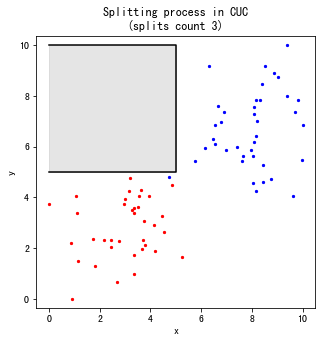

[INFO] CUC.fit(): current_index: 4 	 cur_target: 0


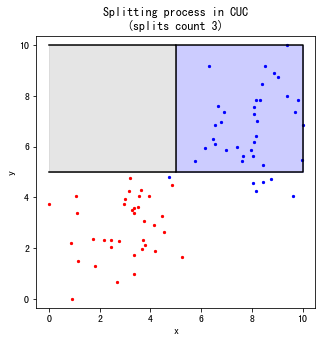

[INFO] CUC.fit(): current_index: 5 	 cur_target: 1


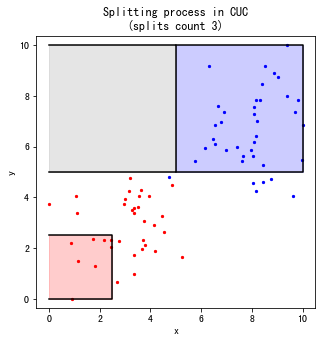

[INFO] CUC.fit(): current_index: 6 	 cur_target: 1


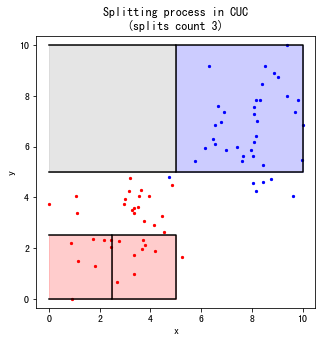

[INFO] CUC.fit(): current_index: 7 	 cur_target: 1


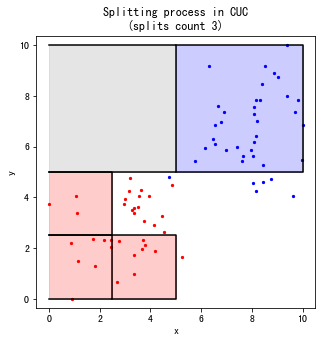

[INFO] CUC.fit(): current_index: 8 	 cur_target: -1


[INFO] -------------split-------------
new_dL: 1.25
new_combination:
[[2.5, 2.5], [3.75, 2.5], [2.5, 3.75], [3.75, 3.75]]
[INFO] CUC.fit(): current_index: 9 	 cur_target: 1


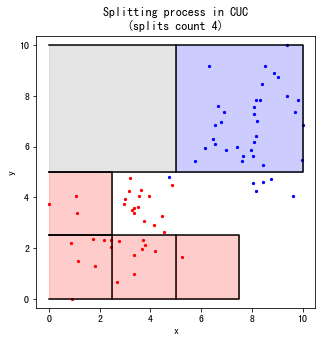

[INFO] CUC.fit(): current_index: 10 	 cur_target: -2


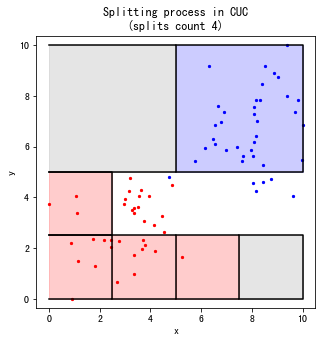

[INFO] CUC.fit(): current_index: 11 	 cur_target: -2


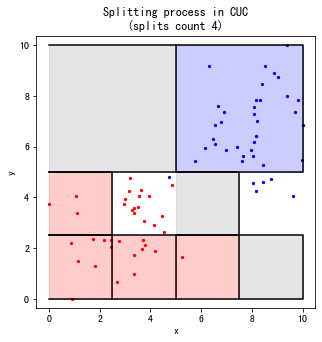

[INFO] CUC.fit(): current_index: 12 	 cur_target: 0


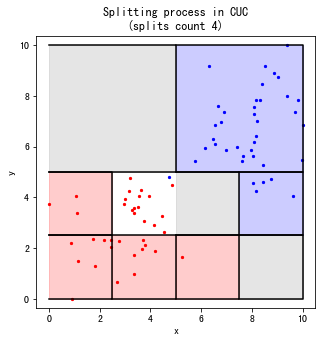

[INFO] CUC.fit(): current_index: 13 	 cur_target: 1


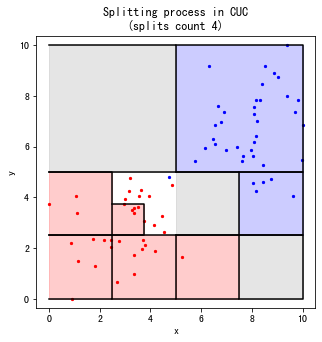

[INFO] CUC.fit(): current_index: 14 	 cur_target: 1


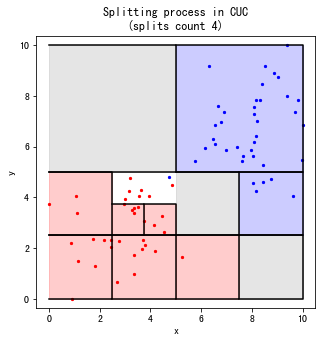

[INFO] CUC.fit(): current_index: 15 	 cur_target: 1


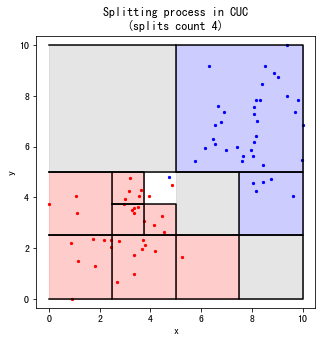

[INFO] CUC.fit(): current_index: 16 	 cur_target: -1


[INFO] -------------split-------------
new_dL: 0.625
new_combination:
[[3.75, 3.75], [4.375, 3.75], [3.75, 4.375], [4.375, 4.375]]
[INFO] CUC.fit(): current_index: 17 	 cur_target: 1


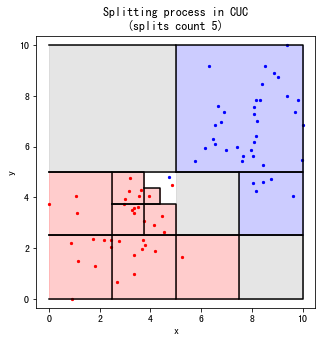

[INFO] CUC.fit(): current_index: 18 	 cur_target: -2


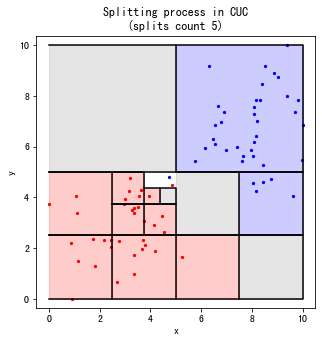

[INFO] CUC.fit(): current_index: 19 	 cur_target: -2


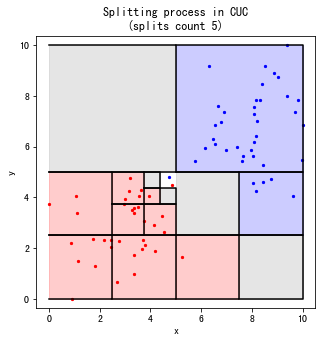

[INFO] CUC.fit(): current_index: 20 	 cur_target: -1


[INFO] -------------split-------------
new_dL: 0.3125
new_combination:
[[4.375, 4.375], [4.6875, 4.375], [4.375, 4.6875], [4.6875, 4.6875]]
[INFO] CUC.fit(): current_index: 21 	 cur_target: -2


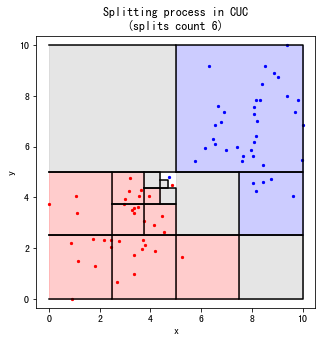

[INFO] CUC.fit(): current_index: 22 	 cur_target: 1


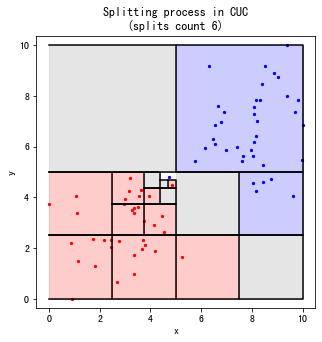

[INFO] CUC.fit(): current_index: 23 	 cur_target: -2


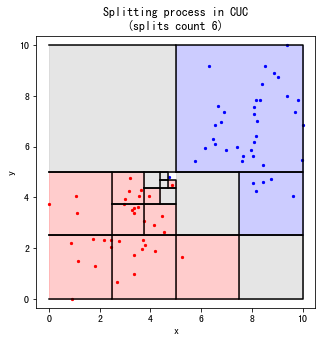

[INFO] CUC.fit(): current_index: 24 	 cur_target: 0


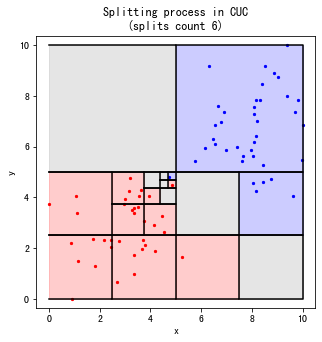



[INFO] -------------split-------------
new_dL: 5.0
new_combination:
[[0.0, 0.0], [5.0, 0.0], [0.0, 5.0], [5.0, 5.0]]


[INFO] -------------split-------------
new_dL: 2.5
new_combination:
[[0.0, 0.0], [2.5, 0.0], [0.0, 2.5], [2.5, 2.5]]


[INFO] -------------split-------------
new_dL: 2.5
new_combination:
[[5.0, 0.0], [7.5, 0.0], [5.0, 2.5], [7.5, 2.5]]


[INFO] -------------split-------------
new_dL: 2.5
new_combination:
[[0.0, 5.0], [2.5, 5.0], [0.0, 7.5], [2.5, 7.5]]


[INFO] -------------split-------------
new_dL: 2.5
new_combination:
[[5.0, 5.0], [7.5, 5.0], [5.0, 7.5], [7.5, 7.5]]


[INFO] -------------split-------------
new_dL: 1.25
new_combination:
[[0.0, 0.0], [1.25, 0.0], [0.0, 1.25], [1.25, 1.25]]


[INFO] -------------split-------------
new_dL: 1.25
new_combination:
[[2.5, 0.0], [3.75, 0.0], [2.5, 1.25], [3.75, 1.25]]


[INFO] -------------split-------------
new_dL: 1.25
new_combination:
[[0.0, 2.5], [1.25, 2.5], [0.0, 3.75], [1.25, 3.75]]


[INFO] -------------split------

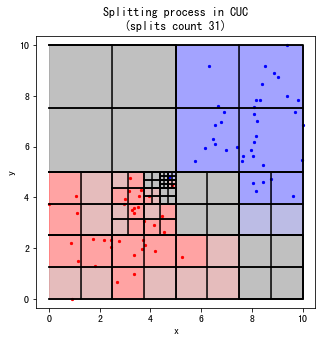

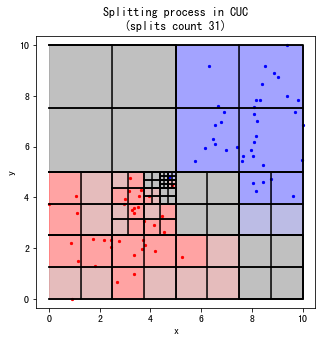

In [589]:
estimator = CodingUnitClassifier(num_refinement_splits=1, is_draw_2D=True, color_map=('blue', 'red'), pic_save_path='./output/CUC')
estimator.fit(X=x_train, y=y_train)

In [595]:
pd.DataFrame(pd.DataFrame(estimator.arrCU_start_points), 
             pd.Series(estimator.arrCU_is_enable), axis=1)

TypeError: __init__() got an unexpected keyword argument 'axis'

In [597]:
pd.Series(estimator.arrCU_is_enable)

0      False
1      False
2      False
3      False
4      False
       ...  
121     True
122     True
123     True
124     True
125     True
Length: 126, dtype: bool